In [1]:
# 4種模型 vgg16 , resnet50, densenet121, InceptionResNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input as preprocess_input_densenet
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as preprocess_input_inceptionresnetv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
import numpy as np
from numpy import linalg as LA
import os
import h5py
# model = VGG16(weights='imagenet', include_top=False)
# img_path = './images2/089037468.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# features = model.predict(x)

In [2]:
class VGGNet:
    def __init__ (self):
        self.input_shape = (224,224,3)
        self.weight = 'imagenet'
        self.pooling = 'max'
        # VGG16
        self.model_vgg = VGG16(weights=self.weight,
                              input_shape = (self.input_shape[0],self.input_shape[1], self.input_shape[2]),
                              pooling = self.pooling, include_top = False)
        self.model_vgg.predict(np.zeros((1,224,224,3)))
        
        # ResNet50
        self.model_resnet = ResNet50(weights = self.weight, 
                                     input_shape = (self.input_shape[0], self.input_shape[1], self.input_shape[2]),
                                     pooling = self.pooling, include_top = False)
        self.model_resnet.predict(np.zeros((1, 224, 224, 3)))
        
        # DenseNet121
        self.model_densenet = DenseNet121(weights = self.weight, 
                                          input_shape = (self.input_shape[0], self.input_shape[1], self.input_shape[2]), 
                                          pooling = self.pooling, include_top = False)
        self.model_densenet.predict(np.zeros((1, 224, 224, 3)))
        
#         keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet',
#                                                                  input_tensor=None, input_shape=None, 
#                                                                  pooling=None, classes=1000)
        # DenseNet121
        self.model_inceptionresnetv2 = InceptionResNetV2(weights = self.weight, 
                                          input_shape = (self.input_shape[0], self.input_shape[1], self.input_shape[2]), 
                                          pooling = self.pooling, include_top = False)
        self.model_inceptionresnetv2.predict(np.zeros((1, 224, 224, 3)))
        
    # 提取最後一層conz特徵
    def extract_feat(self, img_path):
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(self.input_shape[0], self.input_shape[1]))
        img = keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input_densenet(img)
        feat = self.model_densenet.predict(img)
        # print(feat.shape)
        norm_feat = feat[0]/LA.norm(feat[0])
        return norm_feat
    

In [3]:
def get_imlist(path):
    return [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]

In [4]:
if __name__=="__main__":
    database = 'images2'
    index = 'models/vgg_featureCNN.h5'
    img_list = get_imlist(database)
    

    print("--------------------------------------------------")
    print("               feature extraction starts ")
    print("--------------------------------------------------")
    
    
    feats = []
    names = []
    
    model = VGGNet()
    for i, img_path in enumerate(img_list): 
        
        norm_feat = model.extract_feat(img_path)      
        
        img_name = os.path.split(img_path)[1]
        feats.append(norm_feat)
        names.append(img_name)
        print('extracting featurn from image NO. %d , %d images in total' %((i + 1),len(img_list)))
        
    feats = np.array(feats)
    output = index
    
    print("--------------------------------------------------")
    print("               writing feature extraction results")
    print("--------------------------------------------------")
    
    h5f = h5py.File(output, 'w')
    h5f.create_dataset('dataset_1',data = feats)
    h5f.create_dataset('dataset_2',data = np.string_(names))

    h5f.close()
   

--------------------------------------------------
               feature extraction starts 
--------------------------------------------------
extracting featurn from image NO. 1 , 106 images in total
extracting featurn from image NO. 2 , 106 images in total
extracting featurn from image NO. 3 , 106 images in total
extracting featurn from image NO. 4 , 106 images in total
extracting featurn from image NO. 5 , 106 images in total
extracting featurn from image NO. 6 , 106 images in total
extracting featurn from image NO. 7 , 106 images in total
extracting featurn from image NO. 8 , 106 images in total
extracting featurn from image NO. 9 , 106 images in total
extracting featurn from image NO. 10 , 106 images in total
extracting featurn from image NO. 11 , 106 images in total
extracting featurn from image NO. 12 , 106 images in total
extracting featurn from image NO. 13 , 106 images in total
extracting featurn from image NO. 14 , 106 images in total
extracting featurn from image NO. 15 , 

[[8.34988077e-06 2.65377894e-04 6.50839793e-05 ... 4.27869223e-02
  3.87354866e-02 2.54755095e-02]
 [8.52746143e-06 4.72711370e-04 8.88837458e-05 ... 3.37099247e-02
  5.14929406e-02 7.37165241e-03]
 [1.37333227e-05 2.77333165e-04 1.16286996e-04 ... 6.17939569e-02
  8.97993334e-03 3.17856744e-02]
 ...
 [7.64291599e-06 1.91001207e-04 6.23704036e-05 ... 7.53181204e-02
  1.73994545e-02 2.23034602e-02]
 [1.41561941e-05 2.10902625e-04 6.23052765e-05 ... 6.76368698e-02
  1.76535789e-02 7.84180500e-03]
 [7.07723075e-06 2.45151459e-04 4.06923864e-05 ... 3.77186164e-02
  7.15439841e-02 9.49390419e-03]]
[b'089037461.jpg' b'089037462.jpg' b'089037463.jpg' b'089037464.jpg'
 b'089037465.jpg' b'089037466.jpg' b'089037467.jpg' b'089037468.jpg'
 b'089037469.jpg' b'089037470.jpg' b'089037471.jpg' b'089037472.jpg'
 b'089037473.jpg' b'089037474.jpg' b'089037475.jpg' b'089037476.jpg'
 b'089037477.jpg' b'089037478.jpg' b'089037479.jpg' b'089037480.jpg'
 b'089037481.jpg' b'089037482.jpg' b'089037483.jpg' b'0

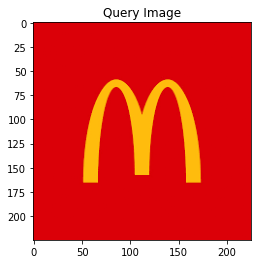

[0.73019636 0.7207941  0.70387954 0.69817525 0.68484575 0.6658877
 0.66234595 0.6611013  0.65348005 0.64779234 0.6448014  0.6342248
 0.62736005 0.6261388  0.6260389  0.62491894 0.6246341  0.6242498
 0.62408686 0.61647135 0.61618006 0.6141889  0.6139216  0.61179286
 0.6070409  0.6042217  0.6037002  0.6022146  0.6017913  0.60139036
 0.6005644  0.60027564 0.5968957  0.5956257  0.5947118  0.5910995
 0.5899552  0.5892814  0.58742225 0.5873811  0.5821005  0.5755415
 0.5753828  0.57265997 0.5702026  0.56962    0.56924915 0.567107
 0.5652339  0.56519777 0.5613186  0.5609423  0.5595364  0.5592637
 0.55579394 0.5544819  0.5495167  0.54898584 0.54851043 0.5469456
 0.5450051  0.54496896 0.5439921  0.5438603  0.54219496 0.54176617
 0.5373569  0.53697145 0.5353488  0.5345794  0.5332285  0.5332197
 0.5327332  0.5325798  0.5309354  0.53081304 0.52703667 0.5257051
 0.51906204 0.5185952  0.51723164 0.515342   0.515259   0.51432014
 0.5075952  0.5069782  0.50695103 0.50619894 0.5004908  0.4998733
 0.4876

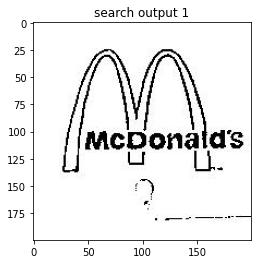

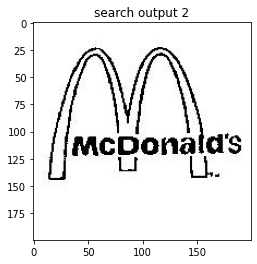

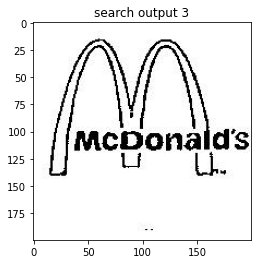

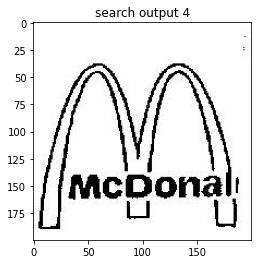

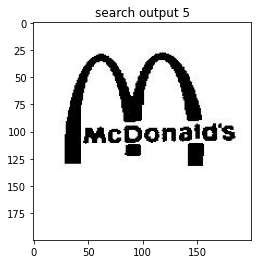

In [5]:
#  test.py
# -*- coding: utf-8 -*-
# from extract_cnn_vgg16_keras import VGGNet
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import argparse

query = './database/MDlogo.jpg'
index = 'models/vgg_featureCNN.h5'
result = 'images2'
# read in indexed images' feature vectors and corresponding image names
h5f = h5py.File(index,'r')
# feats = h5f['dataset_1'][:]
feats = h5f['dataset_1'][:]
print(feats)
imgNames = h5f['dataset_2'][:]
print(imgNames)
h5f.close()
        
print("--------------------------------------------------")
print("               searching starts")
print("--------------------------------------------------")
    
# read and show query image
# queryDir = args["query"]
queryImg = mpimg.imread(query)
plt.title("Query Image")
plt.imshow(queryImg)
plt.show()

# init VGGNet16 model
model = VGGNet()

# extract query image's feature, compute simlarity score and sort 

queryVec = model.extract_feat(query)

# print(queryVec.shape)
# print(feats.shape)
scores = np.dot(queryVec, feats.T)
rank_ID = np.argsort(scores)[::-1]
rank_score = scores[rank_ID]
# print (rank_ID)
print (rank_score)


# number of top retrieved images to show
maxres = 5          #檢索出三張相似度最高的圖片
imlist = []
for i,index in enumerate(rank_ID[0:maxres]):
    imlist.append(imgNames[index])
    # print(type(imgNames[index]))
    print("image names: "+str(imgNames[index]) + " scores: %f"%rank_score[i])
print("top %d images in order are: " %maxres, imlist)
# show top #maxres retrieved result one by one
for i,im in enumerate(imlist):
    image = mpimg.imread(result+"/"+str(im, 'utf-8'))
    plt.title("search output %d" %(i+1))
    plt.imshow(image)
    plt.show()